### Design of RO unit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

In [3]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'

In [4]:
def get_C_red(x):
    '''
    S = area of membrane [m2]
    delta_p = pressure diff [Pa]
    PR = pure water flow rate [m3/hr]
    f = recovery [-]
    eta_p = pump eff. [-]
    eta_t = turbine eff. [-]
    elec_cost = cost of indust. elec. in Cali. [$/kwh]
    time_running = years plant is operating [yr]

    C_red = cost funtion, to be minimised [$]
    '''

    S, delta_p, m3 = x
    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p*PR/3600*(1/eta_p) # power of pump [Nm/s]
    P_turbine = delta_p*(PR/f-PR)/3600*eta_t # power recovered by turbine [Nm/s]
    P_tot = (P_pump - P_turbine)/3.6e6 # [kwh/s]
    OPEX_per_s = (P_tot*elec_cost) # [$/s]
    OPEX = OPEX_per_s*time_running*8000*3600 # [$]

    membrane_cost = S*150 # [$]

    C_red = membrane_cost + OPEX
    return C_red

Equality constraint: $ \frac{A(\Delta p - \Delta \pi )\times M_B \times S \times 3600}{\frac{1000}{1000+m_3\times M_A}} - PR = 0; ~where~\Delta \pi = \sum_i R T C_{i,~feed} -  \sum_i R T C_{i,~permeate}$

In [5]:
def constraint1(x):

    S, delta_p, m3 = x

    M_A = 58.44 # [g/mol]
    M_B = 18.02 # [g/mol]
    A = 3e-7 # [kmol/(m^2skPa)]
    PR = 1500 # [m^3/hr]
    rho = 997 # [kg/m^3]
    m1 = 0.6 # [M]

    delta_pi = 0.0821*298*((m1+m1)-(m3+m3)) # using eq. above this is in atm
    delta_pi = delta_pi*101300 # atm -> Pa

    J_B = A*(delta_p/1000-delta_pi/1000) # ensuring kPa units
    cons1 = (J_B*M_B*S*3600)/(1000/(1000+m3*M_A))-PR*rho
    return cons1

$\Delta p - 800 \geq 0$ and $1000 -\Delta p\geq 0$ 
Note: this is in the form $g(x) \geq 0$

$S \geq 0$

$m_3 \geq 0$ and $0.005 - m_3 \geq 0 $

In [6]:
bounds = [(1e-6, 1e7), (5.516e6, 6.895e6), (0, 0.005)]

In [7]:
constraints = [{"type": "ineq", "fun": constraint1}]

In [8]:
x0 = [23800, 6.7e6, 0.005]

In [9]:
result = minimize(get_C_red, x0, bounds=bounds, constraints=constraints)
print("Optimal Solution:", result.x)
print("Minimum Cost:", result.fun)
print("inital constraint :", constraint1(x0))
print("Constraint :", constraint1([result.x[0], result.x[1], result.x[2]]))

Optimal Solution: [2.04819695e+04 6.69995247e+06 5.00000000e-03]
Minimum Cost: 12080009.303787978
inital constraint : 242289.48698598612
Constraint : 0.01090388116426766


In [10]:
def get_C_red(x):
    S, delta_p = x  
    m3 = 0.005  # Fix m3 at 0.005

    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p * PR / 3600 * (1 / eta_p)  # power of pump [Nm/s]
    P_turbine = delta_p * (PR / f - PR) / 3600 * eta_t  # power recovered by turbine [Nm/s]
    P_tot = (P_pump - P_turbine) / 3.6e6  # [kwh/s]
    OPEX_per_s = P_tot * elec_cost  # [$/s]
    OPEX = OPEX_per_s * time_running * 8000 * 3600  # [$]

    membrane_cost = S * 150  # [$]

    C_red = membrane_cost + OPEX
    return C_red

def constraint1(x):
    S, delta_p = x  
    m3 = 0.005  

    M_A = 58.44  # [g/mol]
    M_B = 18.02  # [g/mol]
    A = 3e-7  # [kmol/(m^2skPa)]
    PR = 1500  # [m^3/hr]
    rho = 997  # [kg/m^3]
    m1 = 0.6  # [M]

    delta_pi = 0.0821 * 298 * ((m1 + m1) - (m3 + m3))  # using eq. above this is in atm
    delta_pi = delta_pi * 101300  # atm -> Pa

    J_B = A * (delta_p / 1000 - delta_pi / 1000)  
    cons1 = (J_B * M_B * S * 3600) / (1000 / (1000 + m3 * M_A)) - PR * rho
    return cons1

bounds = [(1e-6, 1e7), (5.516e6, 6.895e6)]

constraints = [{"type": "ineq", "fun": constraint1}]

x0 = [26240, 5.87e6] 

result = minimize(get_C_red, x0, bounds=bounds, constraints=constraints, method='SLSQP')

print("Optimal Solution:", result.x)
print("Minimum Cost:", result.fun)
print("inital constraint:", constraint1(x0))
print("Constraint Value at Optimal Solution:", constraint1(result.x))

Optimal Solution: [  26302.12735317 5870000.08455761]
Minimum Cost: 11837208.105547968
inital constraint: -3532.512466052547
Constraint Value at Optimal Solution: 1.1292286217212677e-07


C:\Users\fjm21\AppData\Local\Temp\ipykernel_26468\768326452.py:70: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(S_values, delta_p_values, constraint_values, levels=[0], colors='k', linewidths=2, label="Constraint Boundary")


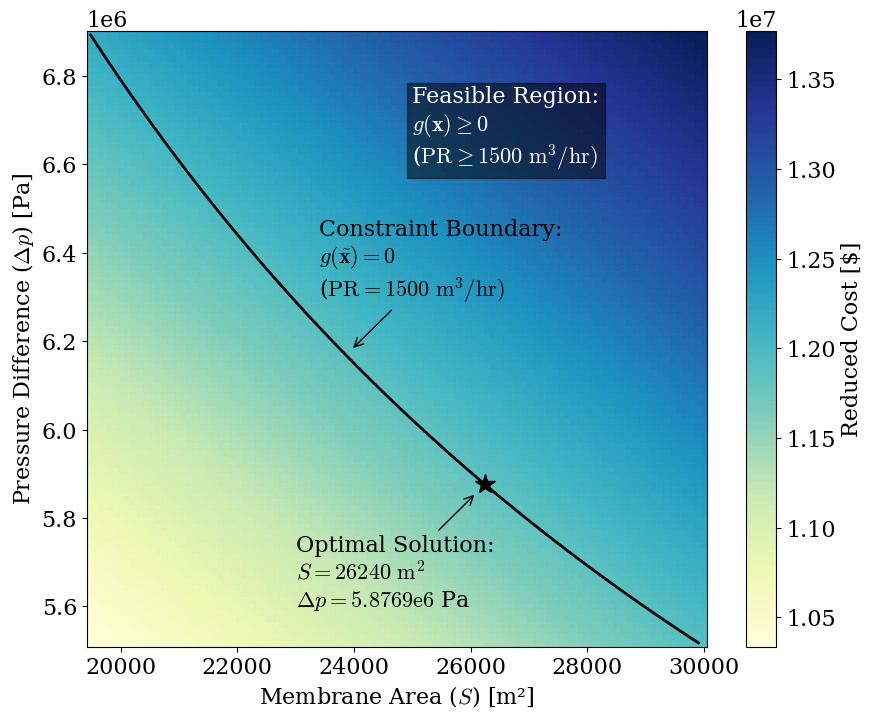

In [11]:
def constraint1(x):
    S, delta_p, m3 = x
    M_A = 58.44 # [g/mol]
    M_B = 18.02 # [g/mol]
    A = 3e-7 # [kmol/(m^2skPa)]
    PR = 1500 # [m^3/hr]
    rho = 997 # [kg/m^3]
    m1 = 0.6 # [M]

    delta_pi = 0.0821*298*((m1+m1)-(m3+m3)) # using eq. above this is in atm
    delta_pi = delta_pi*101300 # atm -> Pa

    J_B = A*(delta_p/1000 - delta_pi/1000) # ensuring kPa units
    cons1 = (J_B*M_B*S*3600)/(1000/(1000+m3*M_A))-PR*rho
    return cons1

# Define the cost function (get_C_red)
def get_C_red(x):
    '''
    S = area of membrane [m2]
    delta_p = pressure diff [Pa]
    PR = pure water flow rate [m3/hr]
    f = recovery [-]
    eta_p = pump eff. [-]
    eta_t = turbine eff. [-]
    elec_cost = cost of indust. elec. in Cali. [$/kwh]
    time_running = years plant is operating [yr]

    C_red = cost function, to be minimised [$]
    '''
    S, delta_p, m3 = x
    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p*PR/3600*(1/eta_p) # power of pump [Nm/s]
    P_turbine = delta_p*(PR/f-PR)/3600*eta_t # power recovered by turbine [Nm/s]
    P_tot = (P_pump - P_turbine)/3.6e6 # [kwh/s]
    OPEX_per_s = (P_tot*elec_cost) # [$/s]
    OPEX = OPEX_per_s*time_running*8000*3600 # [$]

    membrane_cost = S*150 # [$]
    C_red = membrane_cost + OPEX
    return C_red

delta_p_values = np.linspace(5.516e6, 6.895e6, 100)  # Bounds for delta_p
S_values = np.linspace(19470, 30000, 100)  # Bounds for S

m3_fixed = 0.005
constraint_values = np.zeros((len(delta_p_values), len(S_values)))
cost_values = np.zeros((len(delta_p_values), len(S_values)))

for i, delta_p in enumerate(delta_p_values):
    for j, S in enumerate(S_values):
        constraint_values[i, j] = constraint1([S, delta_p, m3_fixed])
        cost_values[i, j] = get_C_red([S, delta_p, m3_fixed])

plt.figure(figsize=(10, 8))

plt.pcolormesh(S_values, delta_p_values, cost_values, shading='auto', cmap='YlGnBu')
cbar = plt.colorbar(label=r'Reduced Cost [\$]')
cbar.set_label(r'Reduced Cost [\$]', fontsize=16)  
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.offsetText.set_fontsize(16)
plt.pcolormesh(S_values, delta_p_values, cost_values, shading='auto', cmap='YlGnBu', antialiased=False)

plt.contour(S_values, delta_p_values, constraint_values, levels=[0], colors='k', linewidths=2, label="Constraint Boundary")

plt.xlabel(r'Membrane Area ($S$) [m²]', fontsize=16)
plt.ylabel(r'Pressure Difference ($\Delta p$) [Pa]', fontsize=16)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  
ax = plt.gca()  
ax.yaxis.offsetText.set_fontsize(16)

plt.annotate(
    r"Constraint Boundary:" + "\n"r"$g(\mathbf{\tilde{x}})=0$" + "\n" + r"($\mathrm{PR} = 1500~\mathrm{m^3/hr})$",
    xy=(23950, 6.18e6),  # Coordinates of the arrow tip (where the label points)
    xytext=(23400, 6.3e6),  # Coordinates of the text
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=16
)

plt.text(
    25000, 6.6e6,  # Coordinates for the text
    "Feasible Region:" + "\n""$g(\mathbf{x}) \geq 0$" + "\n" + r"($\mathrm{PR} \geq 1500~\mathrm{m^3/hr})$", 
    fontsize=16,
    color='white',
    bbox=dict(facecolor='black', alpha=0.5)  # Optional for a background box
)


# plt.text(
#     28000, 6.8e6,  # Coordinates for the text
#     r"High Cost", 
#     fontsize=16,
#     color='white',
#     #bbox=dict(facecolor='black', alpha=0.5)  # Optional for a background box
# )

star_x = 26240
star_y = 5.8769e6

plt.plot(star_x, star_y, marker='*', color='black', markersize=15)

plt.annotate(
    r"Optimal Solution:" + "\n"r"$S = 26240~\mathrm{m^2}$" + "\n" + r"$\Delta p = 5.8769\mathrm{e}6$ Pa",
    xy=(26100, 5.8569e6),  # Coordinates of the arrow tip (where the label points)
    xytext=(23000, 5.6e6),  # Coordinates of the text
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=16
)

plt.savefig(r'C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\Membranes\CW\figure.pdf', format='pdf', transparent=False)

plt.show()


### Sens.

In [12]:
def f(delta_p):
    delta_p = delta_p*1e6
    m3 = 0.005
    M_A = 58.44 # [g/mol]
    M_B = 18.02 # [g/mol]
    A = 3e-7 # [kmol/(m^2skPa)]
    PR = 1500 # [m^3/hr]
    rho = 997 # [kg/m^3]
    m1 = 0.6 # [M]

    delta_pi = 0.0821*298*((m1+m1)-(m3+m3)) # using eq. above this is in atm
    delta_pi = delta_pi * 101325

    J_B = A*(delta_p/1000 - delta_pi/1000) # ensuring kPa units
    #J_B = 0.000975
    S = 1/((J_B*M_B*3600)/(1000/(1000+m3*M_A)*PR*rho))

    return S 

In [13]:
test = f(6.2)
print(test)

23637.335561851327


In [14]:
def add_arrow(line, position=None, direction='right', size=25, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """

    if isinstance(line, list):
        line = line[0]
        
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size,

    )

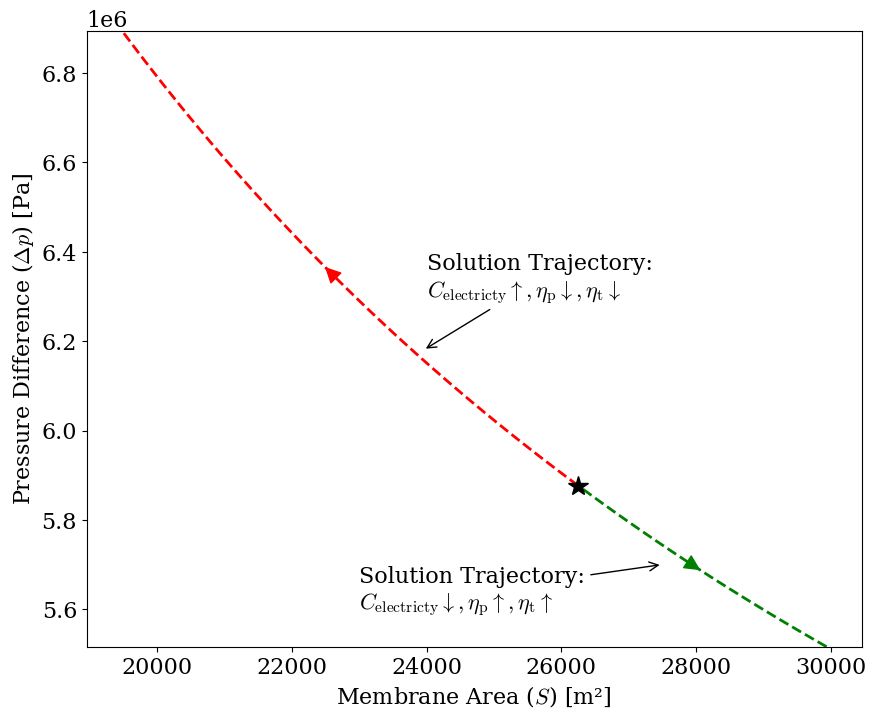

In [15]:
delta_p_values = np.linspace(5.516e6, 6.895e6, 100)  # Bounds for delta_p
S_values = np.linspace(19470, 30000, 100)  # Bounds for S

m3_fixed = 0.005
constraint_values = np.zeros((len(delta_p_values), len(S_values)))
cost_values = np.zeros((len(delta_p_values), len(S_values)))

for i, delta_p in enumerate(delta_p_values):
    for j, S in enumerate(S_values):
        constraint_values[i, j] = constraint1([S, delta_p, m3_fixed])
        cost_values[i, j] = get_C_red([S, delta_p, m3_fixed])

plt.figure(figsize=(10, 8))

# plt.pcolormesh(S_values, delta_p_values, cost_values, shading='auto', cmap='YlGnBu')
# cbar = plt.colorbar(label=r'Reduced Cost [\$]')
# cbar.set_label(r'Reduced Cost [\$]', fontsize=16)  
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.offsetText.set_fontsize(16)
# plt.pcolormesh(S_values, delta_p_values, cost_values, shading='auto', cmap='YlGnBu', antialiased=False)

#plt.contour(S_values, delta_p_values, constraint_values, levels=[0], colors='k', linewidths=2, label="Constraint Boundary")

delta_p_values = np.linspace(5.516, 5.8769, 100)  
S_values = []  
for delta_p in delta_p_values:
    S_values.append(f(delta_p))

S_values = np.array(S_values)

line=plt.plot(S_values, delta_p_values*1e6, color='g', linewidth=2, linestyle = '--')

delta_p_values2 = np.linspace(5.8769, 6.895, 100)  
S_values2 = []  
for delta_p in delta_p_values2:
    S_values2.append(f(delta_p))

S_values2 = np.array(S_values2)

line2=plt.plot(S_values2, delta_p_values2*1e6, color='r', linewidth=2, linestyle = '--')

plt.xlabel(r'Membrane Area ($S$) [m²]', fontsize=16)
plt.ylabel(r'Pressure Difference ($\Delta p$) [Pa]', fontsize=16)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  
ax = plt.gca()  
ax.yaxis.offsetText.set_fontsize(16)

plt.annotate(
    r"Solution Trajectory:" + "\n"r"$C_\mathrm{electricty} \uparrow, \eta_\mathrm{p} \downarrow, \eta_\mathrm{t} \downarrow$",
    xy=(23950, 6.18e6),  # Coordinates of the arrow tip (where the label points)
    xytext=(24000, 6.3e6),  # Coordinates of the text
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=16
)

star_x = 26240
star_y = 5.8769e6

plt.plot(star_x, star_y, marker='*', color='black', markersize=15)

plt.annotate(
    r"Solution Trajectory:" + "\n"r"$C_\mathrm{electricty} \downarrow, \eta_\mathrm{p} \uparrow, \eta_\mathrm{t} \uparrow$",
    xy=(27500, 5.7e6),  # Coordinates of the arrow tip (where the label points)
    xytext=(23000, 5.6e6),  # Coordinates of the text
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=16
)

add_arrow(line, direction='left')
add_arrow(line2, direction='right')
plt.ylim(5.516e06, 6.895e6)

plt.savefig(r'C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\Membranes\CW\objective_sens_1.pdf', format='pdf', transparent=False)

plt.show()


In [16]:
 f(6.31)-f(6.3)

-68.2493673859899

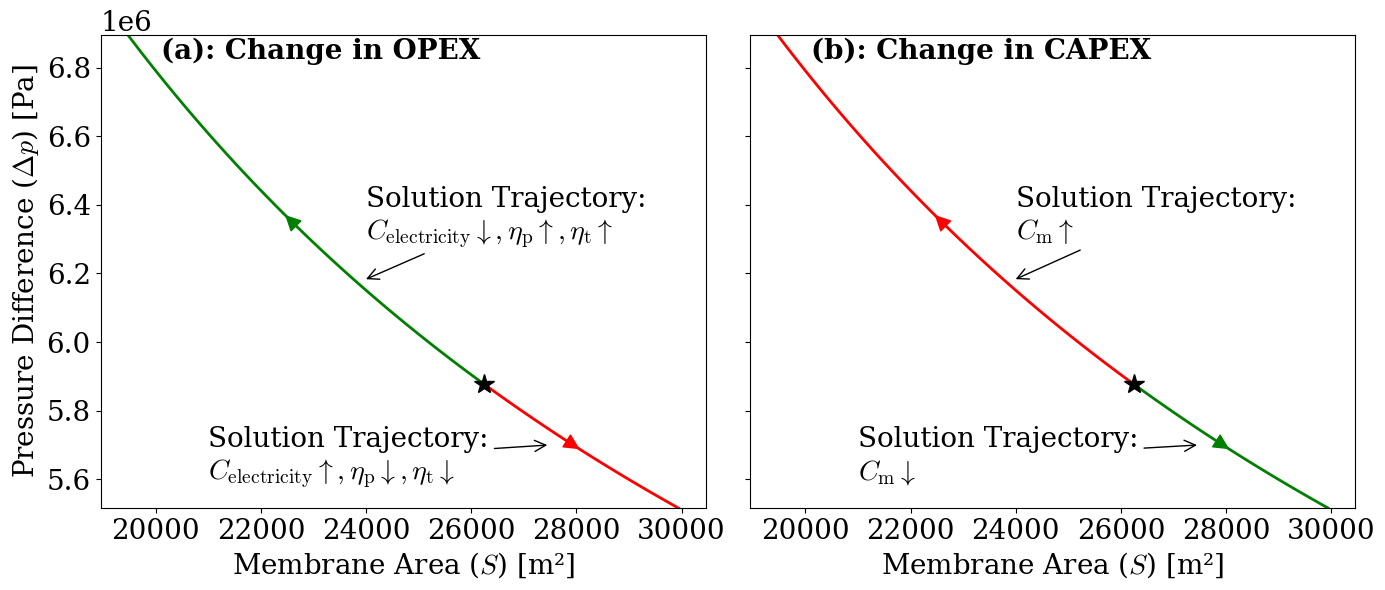

In [17]:
# --- Precompute values (as in your code) ---
delta_p_values = np.linspace(5.516e6, 6.895e6, 100)
S_values_grid = np.linspace(19470, 30000, 100)

m3_fixed = 0.005
constraint_values = np.zeros((len(delta_p_values), len(S_values_grid)))
cost_values = np.zeros((len(delta_p_values), len(S_values_grid)))

for i, delta_p in enumerate(delta_p_values):
    for j, S in enumerate(S_values_grid):
        constraint_values[i, j] = constraint1([S, delta_p, m3_fixed])
        cost_values[i, j] = get_C_red([S, delta_p, m3_fixed])

# --- Get solution trajectories ---
delta_p1 = np.linspace(5.516, 5.8769, 100)
S1 = np.array([f(p) for p in delta_p1])
delta_p2 = np.linspace(5.8769, 6.895, 100)
S2 = np.array([f(p) for p in delta_p2])

# --- Create figure with subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for idx, ax in enumerate(axes):
    if idx == 0:
        # First plot: green and red dashed lines
        ax.plot(S1, delta_p1 * 1e6, color='r', linewidth=2, linestyle='-')
        ax.plot(S2, delta_p2 * 1e6, color='g', linewidth=2, linestyle='-')
    else:
        # Second plot: blue and orange solid lines
        ax.plot(S1, delta_p1 * 1e6, color='g', linewidth=2, linestyle='-')
        ax.plot(S2, delta_p2 * 1e6, color='r', linewidth=2, linestyle='-')

    ax.plot(26240, 5.8769e6, marker='*', color='black', markersize=15)

    ax.set_xlabel(r'Membrane Area ($S$) [m²]', fontsize=20)
    if idx == 0:
        ax.set_ylabel(r'Pressure Difference ($\Delta p$) [Pa]', fontsize=20)

    ax.tick_params(labelsize=20)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.offsetText.set_fontsize(20)
    ax.set_ylim(5.516e6, 6.895e6)

# --- Add different annotations ---
axes[0].annotate(
    r"Solution Trajectory:" + "\n"r"$C_\mathrm{electricity} \downarrow, \eta_\mathrm{p} \uparrow, \eta_\mathrm{t} \uparrow$",
    xy=(23950, 6.18e6), xytext=(24000, 6.3e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

axes[0].annotate(
    r"Solution Trajectory:" + "\n"r"$C_\mathrm{electricity} \uparrow, \eta_\mathrm{p} \downarrow, \eta_\mathrm{t} \downarrow$",
    xy=(27500, 5.7e6), xytext=(21000, 5.6e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)


axes[1].annotate(
    r"Solution Trajectory:" + "\n"r"$C_\mathrm{m} \uparrow$",
    xy=(23950, 6.18e6), xytext=(24000, 6.3e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

axes[1].annotate(
    r"Solution Trajectory:" + "\n"r"$C_\mathrm{m} \downarrow$",
    xy=(27500, 5.7e6), xytext=(21000, 5.6e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

# --- Label subplots as (a) and (b) ---
axes[0].text(0.1, 0.95, "(a): Change in OPEX", transform=axes[0].transAxes, fontsize=20, fontweight='bold')
axes[1].text(0.1, 0.95, "(b): Change in CAPEX", transform=axes[1].transAxes, fontsize=20, fontweight='bold')

# --- Optional: Add directional arrows if you have the function ---
add_arrow(axes[0].lines[0], direction='left')
add_arrow(axes[0].lines[1], direction='right')
add_arrow(axes[1].lines[0], direction='left')
add_arrow(axes[1].lines[1], direction='right')

# --- Save and show ---
plt.tight_layout()
plt.savefig(r'C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\Membranes\CW\objective_sens_subplots.pdf', format='pdf', transparent=False)
plt.show()


### Import Data from MATLAB

In [18]:
import pandas as pd

In [19]:
file_path = r"C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\Membranes\CW\Sens.xlsx"
df = pd.read_excel(file_path)
df["A_dp"] = df["A_dp"]*6894.76
df["M_dp"] = df["M_dp"]*6894.76
df

,A,A_S,A_dp,M,M_S,M_dp
0,2.400000e-07,29345.521523,6.224094e+06,0.480000,24318.145549,5.515808e+06
1,2.463158e-07,28966.853065,6.181846e+06,0.492632,24809.725331,5.515808e+06
2,2.526316e-07,28602.477994,6.141192e+06,0.505263,25321.589253,5.515808e+06
3,2.589474e-07,28251.512986,6.102035e+06,0.517895,25855.019242,5.515808e+06
4,2.652632e-07,27913.166300,6.064284e+06,0.530526,26247.434778,5.533989e+06
5,2.715789e-07,27586.678329,6.027859e+06,0.543158,26247.433018,5.596616e+06
6,2.778947e-07,27271.394081,5.992682e+06,0.555789,26247.433585,5.659244e+06
7,2.842105e-07,26966.673935,5.958685e+06,0.568421,26247.432633,5.721871e+06
8,2.905263e-07,26671.947823,5.925802e+06,0.581053,26247.432485,5.784498e+06
9,2.968421e-07,26386.678596,5.893975e+06,0.593684,26247.434131,5.847125e+06


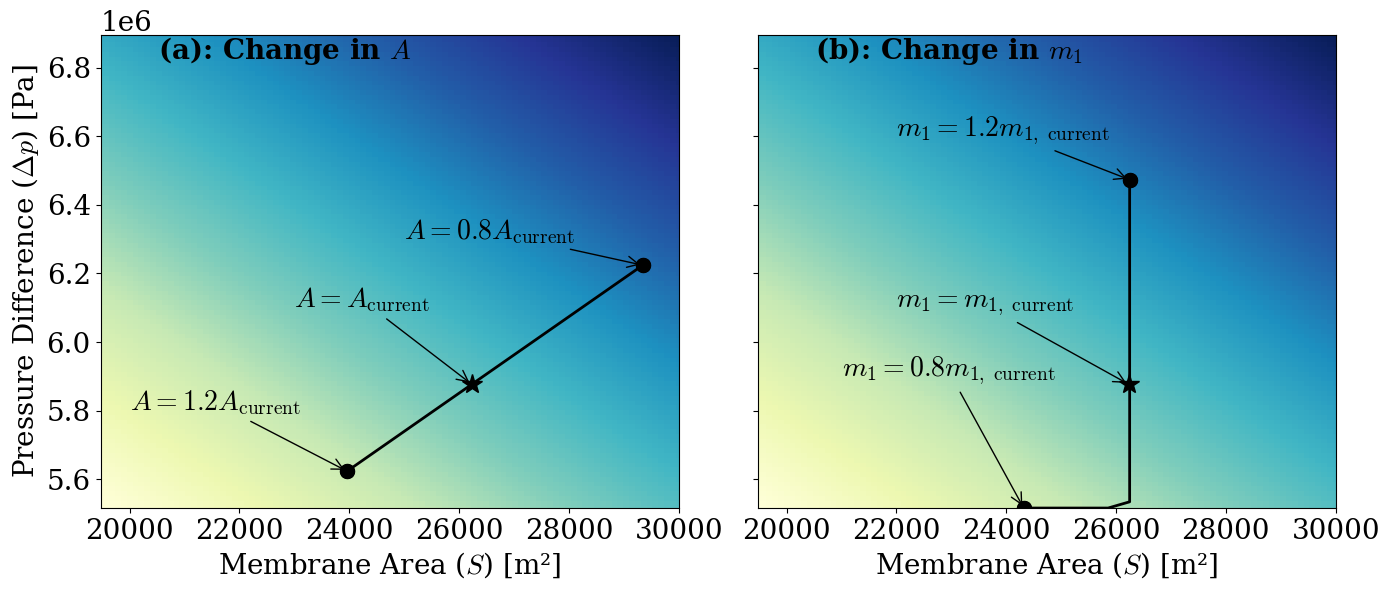

In [20]:
delta_p_values = np.linspace(5.516e6, 6.895e6, 100)
S_values_grid = np.linspace(19470, 30000, 100)

m3_fixed = 0.005
constraint_values = np.zeros((len(delta_p_values), len(S_values_grid)))
cost_values = np.zeros((len(delta_p_values), len(S_values_grid)))

for i, delta_p in enumerate(delta_p_values):
    for j, S in enumerate(S_values_grid):
        constraint_values[i, j] = constraint1([S, delta_p, m3_fixed])
        cost_values[i, j] = get_C_red([S, delta_p, m3_fixed])



fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


for idx, ax in enumerate(axes):
    if idx == 0:
        ax.plot(df["A_S"], df["A_dp"], color='k', linewidth=2, linestyle='-')
        mesh = ax.pcolormesh(S_values_grid, delta_p_values, cost_values, shading='auto', cmap='YlGnBu')
        #ax.plot(S2, delta_p2 * 1e6, color='r', linewidth=2, linestyle='--')
    else:
        # Second plot: blue and orange solid lines
        ax.plot(df["M_S"], df["M_dp"], color='k', linewidth=2, linestyle='-')
        mesh = ax.pcolormesh(S_values_grid, delta_p_values, cost_values, shading='auto', cmap='YlGnBu')
        #ax.plot(S2, delta_p2 * 1e6, color='g', linewidth=2, linestyle='--')

    ax.plot(26240, 5.8769e6, marker='*', color='black', markersize=15)
    axes[0].plot(df["A_S"].iloc[0], df["A_dp"].iloc[0], marker='o', color='black', markersize=10)
    axes[0].plot(df["A_S"].iloc[-1], df["A_dp"].iloc[-1], marker='o', color='black', markersize=10)
    axes[1].plot(df["M_S"].iloc[0], df["M_dp"].iloc[0], marker='o', color='black', markersize=10)
    axes[1].plot(df["M_S"].iloc[-1], df["M_dp"].iloc[-1], marker='o', color='black', markersize=10)

    ax.set_xlabel(r'Membrane Area ($S$) [m²]', fontsize=20)
    if idx == 0:
        ax.set_ylabel(r'Pressure Difference ($\Delta p$) [Pa]', fontsize=20)

    ax.tick_params(labelsize=20)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.offsetText.set_fontsize(20)
    ax.set_ylim(5.516e6, 6.895e6)
  
    ax.set_xlim(19470, 30000)

    # ax.plot([], [], color='black', label='Solution Trajectory')

    # # Display the legend on the subplot
    # ax.legend(fontsize=16)

axes[0].annotate(
    r"$A = 0.8A_\mathrm{current}$",
    xy=(df["A_S"].iloc[0], df["A_dp"].iloc[0]), 
    xytext=(25000, 6.3e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

axes[0].annotate(
    r"$A = 1.2A_\mathrm{current}$",
    xy=(df["A_S"].iloc[-1], df["A_dp"].iloc[-1]), 
    xytext=(20000, 5.8e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

axes[0].annotate(
    r"$A = A_\mathrm{current}$",
    xy=(26230, 5.8769e6), 
    xytext=(23000, 6.1e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)


axes[1].annotate(
    r"$m_1 = 0.8m_{1,~\mathrm{current}}$",
    xy=(df["M_S"].iloc[0], df["M_dp"].iloc[0]), 
    xytext=(21000, 5.9e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

axes[1].annotate(
    r"$m_1 = 1.2m_{1,~\mathrm{current}}$",
    xy=(df["M_S"].iloc[-1], df["M_dp"].iloc[-1]), 
    xytext=(22000, 6.6e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)

axes[1].annotate(
    r"$m_1 = m_{1,~\mathrm{current}}$",
    xy=(26230, 5.8769e6), 
    xytext=(22000, 6.1e6),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=20
)


axes[0].text(0.1, 0.95, r"(a): Change in $A$", transform=axes[0].transAxes, fontsize=20, fontweight='bold')
axes[1].text(0.1, 0.95, r"(b): Change in $m_1$", transform=axes[1].transAxes, fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig(r'C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\Membranes\CW\constraint_sens_subplots.pdf', format='pdf', transparent=False)
plt.show()


In [21]:
df["A_dp"]

0     6.224094e+06
1     6.181846e+06
2     6.141192e+06
3     6.102035e+06
4     6.064284e+06
5     6.027859e+06
6     5.992682e+06
7     5.958685e+06
8     5.925802e+06
9     5.893975e+06
10    5.863147e+06
11    5.833269e+06
12    5.804292e+06
13    5.776168e+06
14    5.748862e+06
15    5.722331e+06
16    5.696542e+06
17    5.671459e+06
18    5.647051e+06
19    5.623288e+06
Name: A_dp, dtype: float64

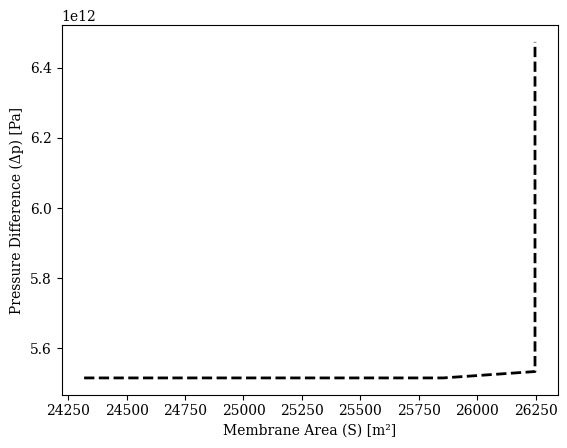

In [22]:
plt.plot(df["M_S"], df["M_dp"] * 1e6, color='k', linewidth=2, linestyle='--')
plt.xlabel('Membrane Area (S) [m²]')
plt.ylabel('Pressure Difference (Δp) [Pa]')
plt.show()